In [1]:
import extract_msg 
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
import glob
import datetime
from IPython.display import clear_output
import numpy as np
import seaborn as sns 
import sensirion_nbconflux
from sensirion_database_access import DatabaseAccess
from sensirion_database_access.pyodbc_access import PyodbcAccess
from sensirion_pmcalib_eval_tools.database_analysis_tool import *
import nbimporter
import sys
%matplotlib inline
%matplotlib inline

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.precision = 2

In [77]:
folder = r"Z:\Bugreport\MadleySorting_Exception"
dictionary_list = []
for i, file in enumerate(os.listdir(folder)):
    try:
        msg = extract_msg.Message(os.path.join(folder, file),overrideEncoding='gbk')
        string = msg.body
        d = {}
        d['AssemblyName'] = re.search(r'Assembly Name: (\w+)', string).group(1)
        d['Version'] = re.search(r'Version Number: (.+?)\r', string).group(1)
        d['Machine'] = re.search(r'Machine Name: (.+?)\r', string).group(1)
        d['DateTime'] = re.search(r'Event Time: (.+?)\r', string).group(1)
        d['WorkingDir'] = re.search(r'Working Directory: (.+?)\r',string).group(1)
        d['file'] = file
        exception = re.search(r'Workflow Exception Message:\r\n(.+?)\r', string).group(1)
        #exception = re.search(r'Other Additional Information Provided By User:\r\n(.+?)\r',re.MULTILINE).group(1)
        # exclude timestamp
        exception = re.sub(r'\[\d{2}:\d{2}:\d{2}\] ', '', exception)
        if "One or more exceptions occured" in exception:
            exception_sum = "The sorting equipment is out of air"
        elif "One or more errors occurred." in exception:
            exception_sum = "Software exception"
        elif "???????" in exception:
            exception_sum = "Software error"
        elif "Error [[Sensirion.PmModules.MadleyCalibration.Configuration.SortingConfigurationContainer.TgWriteFirmware]]"in exception:
            exception_sum = "Error validating section"
        elif "Error [[Sensirion.PmModules.MadleyCalibration.Configuration.Sections.SetupDescription.Site]]" in exception:
            exception_sum = "Property did not validate"
        elif "Error validating binning configuration. File" in exception:
            exception_sum = "Error validating binning configuration"
        elif "Error [[L:\ProductionConfig\PmSorting\SEN6xSorting_config_1.0.0.0\Facility\PmSorting_CN-100873.toml]]" in exception:
            exception_sum = "File not found"
        elif "Error [[Sensirion.PmModules.MadleyCalibration.Configuration.Sections.ZebraLabelPrinter.Enable]]" in exception:
            exception_sum = "Property was not loaded"
        elif "Warning: Ignoring duplicate definition of option ZPL in Printer in file " in exception:
            exception_sum = "Warning"
        elif "PmCalib to Sorting bin mapping failed." in exception:
            exception_sum = "Soft bin is not defined"
        elif "Error [Tomlyn.TomlException:" in exception:
            exception_sum = "Tomlyn error"
        elif "Error validating binning configuration." in exception:
            exception_sum = "Error validating binning configuration."
        elif "Configuration: Failed to connect board '192.168.100.100'" in exception:
            exception_sum = "Failed to connect "
        elif "CtEngine File" in exception:
            exception_sum = "xml does not exist"
        elif "Exception of type 'Ice.MarshalException' was thrown." in exception:
            exception_sum = "Exception of type"
        elif "Timeout while waiting for the cylinders to close" in exception:
            exception_sum = "Closing  door timeout"
        else:
            exception_sum = exception
        d['exception'] = exception_sum
        d['original_exception'] = exception
        dictionary_list.append(d)
    except:
        pass
dft = pd.DataFrame.from_dict(dictionary_list)  

In [78]:
dft.head(2)

,AssemblyName,Version,Machine,DateTime,WorkingDir,file,exception,original_exception
0,SEN6xSorting,1.2.0.0,CN-SHA-M-100068,20.02.2025 12:40:32,C:\SVN\Particle.AppLauncher_5.0.0.0,_Error_ SEN6xSorting _ WorkflowError (1).msg,The sorting equipment is out of air,One or more exceptions occured during executio...
1,SEN6xSorting,1.2.0.0,CN-SHA-M-100068,18.02.2025 15:34:01,C:\SVN\Particle.AppLauncher_5.0.0.0,_Error_ SEN6xSorting _ WorkflowError (10).msg,The sorting equipment is out of air,One or more exceptions occured during executio...


In [79]:
df = dft.copy()
df['Type'] = None
df.loc[df.AssemblyName=='SEN6xSorting', 'Type'] = 'Sorting'
df = df[df.Machine.str.startswith('CN')]
df = df[df.Version.str.match(r"\d*\.\d\.\d\.\d")]
df['DateTime'] = df['DateTime'].map(lambda x: pd.to_datetime(x,dayfirst=True))
df = df.sort_values("DateTime",ascending=False)

In [62]:
df.head(2)

,AssemblyName,Version,Machine,DateTime,WorkingDir,file,exception,original_exception,Type
206,SEN6xSorting,1.2.0.0,CN-SHA-M-100068,2025-02-20 12:48:49,C:\SVN\Particle.AppLauncher_5.0.0.0,_Error_ SEN6xSorting _ WorkflowError .msg,Workflow Exception Message:\r,Workflow Exception Message:\r,Sorting
0,SEN6xSorting,1.2.0.0,CN-SHA-M-100068,2025-02-20 12:40:32,C:\SVN\Particle.AppLauncher_5.0.0.0,_Error_ SEN6xSorting _ WorkflowError (1).msg,Workflow Exception Message:\r,Workflow Exception Message:\r,Sorting


In [55]:
df1=df[df['DateTime']>'2024-11-08 12:32:00']
df1.tail(2)

,AssemblyName,Version,Machine,DateTime,WorkingDir,file,exception,original_exception,Type
113,SEN6xSorting,1.0.0.0,CN-SHA-M-100060,2024-11-08 13:01:06,C:\SVN\SEN6xSorting_1.0.0.0,_Error_ SEN6xSorting _ WorkflowError (200).msg,Workflow Exception Message:,Workflow Exception Message:,Sorting
114,SEN6xSorting,1.0.0.0,CN-SHA-M-100060,2024-11-08 12:32:53,C:\SVN\SEN6xSorting_1.0.0.0,_Error_ SEN6xSorting _ WorkflowError (201).msg,Workflow Exception Message:,Workflow Exception Message:,Sorting


In [56]:
df1['Error'] = df1['exception']

C:\Users\wmao\AppData\Local\Temp\ipykernel_6768\4129736924.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
df2=df1.groupby("Error").size().sort_values(ascending=True).to_frame('Qty')
df2.tail()

,Qty
Error,
Error validating section,9
Soft bin is not defined,9
Software exception,38
Printer is not working,55
The sorting equipment is out of air,65


Text(0.5, 1.0, 'Sorting equipment error statistics chart')

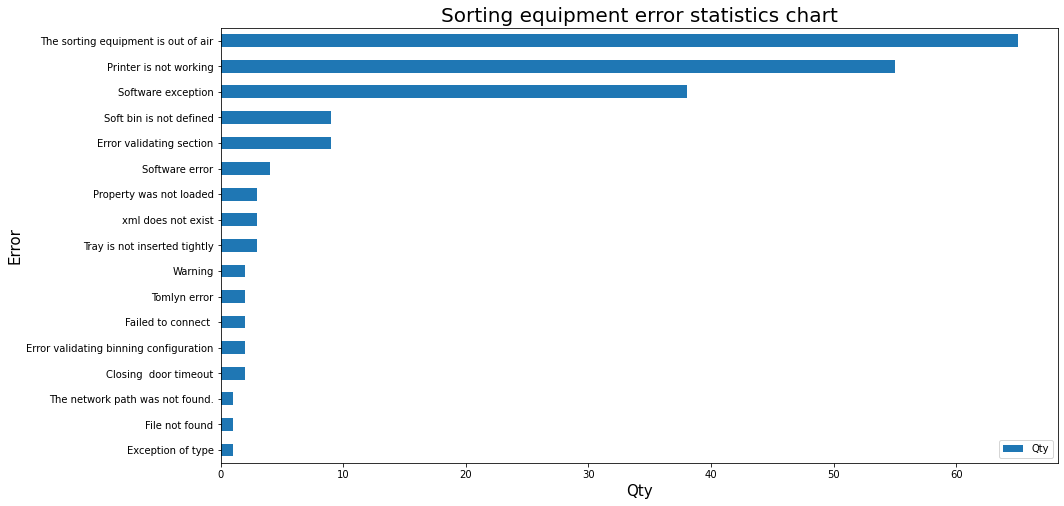

In [9]:
df2.plot.barh(figsize=(15,8),fontsize=10)
plt.xlabel('Qty',fontsize=15)
plt.ylabel('Error',fontsize=15)
plt.title('Sorting equipment error statistics chart',fontsize=20)

In [83]:
da = PyodbcAccess(server_name='CN-SHA-P-MSQS01', db_name='SEN6XDB', db_schema="MS01")
da.connect()
#col_list=['.*']
col_list = ['SubstrateSessionId']
filter_list = ["StartDateTime between '2024-11-01 10:45:31' AND '2025-02-20 12:50:00'"]
df_db = da.fetch(column_list=col_list, filter_list=filter_list, include_limits=True, sort=False,
                 return_testnames=True)

In [81]:
df_db.head(2)

,DeviceId,ProductionOrder,BinCode,SubstrateSessionId
StartDateTime,,,,
2024-11-08 12:32:31,None,92024110801,FF,126
2024-11-08 12:32:31,None,92024110801,FF,126


In [82]:
dfprd=df_db[~df_db.index.duplicated()]
dfprd.tail(2)

,DeviceId,ProductionOrder,BinCode,SubstrateSessionId
StartDateTime,,,,
2025-02-20 12:41:37,None,0003984977,30,792
2025-02-20 12:49:23,None,0003984977,31,793


In [24]:
cycle = dfprd.index.unique().shape[0]
cycle

793

In [25]:
df2['ratio']=df2['Qty']/cycle
df2["ratio"] = df2["ratio"].map(lambda x: '{:.2f}%'.format(x*100))
df2=df2.sort_values("Qty",ascending=False)
df2

,Qty,ratio
Error,,
The sorting equipment is out of air,65,8.20%
Printer is not working,55,6.94%
Software exception,38,4.79%
Soft bin is not defined,9,1.13%
Error validating section,9,1.13%
Software error,4,0.50%
xml does not exist,3,0.38%
Property was not loaded,3,0.38%
Tray is not inserted tightly,3,0.38%


In [63]:
df.to_csv(r"Z:\Bugreport\MadleySorting_Exception\Sen6xSortingError_{}.csv".format(datetime.date.today().strftime("%Y%m%d")),encoding='gbk',index=False)